# Installing the necessary Libraries

In [1]:
!pip install streamlit pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 132.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.1 MB/s eta 0:00:00


In [2]:
!pip install streamlit

# Libraries Imported and loading dataset into Dataframe

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import F for activation functions
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, roc_auc_score,
                             precision_recall_curve, average_precision_score,
                             classification_report)
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)


In [4]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Shuffle data
train = train.sample(frac=1, random_state=1).reset_index(drop=True)
test = test.sample(frac=1, random_state=1).reset_index(drop=True)

# Drop unnecessary columns
train.drop(['keyword', 'location'], axis=1, inplace=True)
test.drop(['keyword', 'location'], axis=1, inplace=True)


Loaded the datasets into dataframes and dropped unnecessary columns from the dataset.

# Preprocessing

In [5]:
# Clean text function
def clean_text(text):
    # Remove unknown characters (emojis, etc.)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'', text)

    # Remove hashtags and mentions
    text = text.replace('#', ' ')
    text = text.replace('@', ' ')

    # Remove special characters
    symbols = re.compile(r'[^A-Za-z0-9 ]')
    text = symbols.sub(r'', text)

    # Convert to lowercase
    text = text.lower()

    return text

# Apply text cleaning
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))


Here we are cleaning the dataset, removing unnecessary emojis, symbols, flags. Then links, hashtags, @ etc are removed as well. Then converted the text to lowercase. Then applied the clean data to the dataframes.

In [6]:
# Load GloVe embeddings
embeddings_index = {}
with open('glove.6B.50d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print(f'Found {len(embeddings_index)} word vectors.')


Found 127764 word vectors.


GloVe embeddings are words and their embeddings which represent the vectors of numbers which has meaning of that particular word in that embeddings. This are extracted from glove.6B.50d.txt file and kept in embeddings_indexas key as word and value as their vector embeddings.

In [7]:
# Prepare embeddings and word indices
word2idx = {}
new_embedding_index = {}

# Build vocabulary and embedding matrix
index = 1  # Start indexing from 1
for dataset in [train, test]:
    for x in dataset['text']:
        words = x.split()
        for word in words:
            if word not in word2idx:
                word2idx[word] = index
                if word in embeddings_index:
                    new_embedding_index[index] = embeddings_index[word]
                else:
                    new_embedding_index[index] = np.random.normal(scale=0.6, size=(50,)).astype(np.float32)
                index += 1

# Add zero vector for padding index
new_embedding_index[0] = np.zeros(50, dtype=np.float32)


Then the datasets are read and each word which is unique is added to a new dictionary with their vectors if in the glovefile or else some randome vector is added. So we now have all words as numbers with their vectors. Words are changed to numbers as numbers are only recognized by the model.

In [8]:
# Save word2idx for later use
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)


These list of words are saved in pickle file which we can easily get whenever we want to.

# Convert tweets to list of Numbers

In [9]:
# Convert text to index sequences
def text_to_sequence(text_list, word2idx):
    sequences = []
    for text in text_list:
        words = text.split()
        seq = [word2idx.get(word, 0) for word in words]
        sequences.append(seq)
    return sequences

train_sequences = text_to_sequence(train['text'], word2idx)
test_sequences = text_to_sequence(test['text'], word2idx)


Here each tweet is obtained and converted to numbers based on the number which is index given to each word.

In [10]:
# Padding sequences
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            padded_sequences[i] = np.array(seq[:maxlen])
        else:
            padded_sequences[i, -len(seq):] = np.array(seq)
    return padded_sequences

max_len = 55  # Based on max length observed
train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)


Padding will be added to each tweet based on max_len, if tweet length is less than max_len then we add zeroes to make it the size of padding length. If not then it is cut to padding length.

In [11]:
# Prepare target variable
train_labels = train['target'].values

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=1)

# Create DataLoaders
batch_size = 64

# Convert to PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

# DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)


Batch_size is set to 64, which means that each time 64 entries will be sent to the model for training, not the entire dataset at once. And the data is also converted into pytorch tensors, easy for working.

In [12]:
# Prepare embedding weights matrix
num_embeddings = len(new_embedding_index)
embedding_dim = 50
weights_matrix = np.zeros((num_embeddings, embedding_dim), dtype=np.float32)
for idx, vec in new_embedding_index.items():
    weights_matrix[idx] = vec
weights_matrix = torch.tensor(weights_matrix)


Weight matrix is defined which will be used to laod on to the model based on the embedding_dimension.

# Logistic Regression(Base model)

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# 3. Prepare Labels
train_labels = train['target'].values

# 4. Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels, test_size=0.2, random_state=1)

# 5. Create TensorDatasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(test_padded))  # only inputs for test set

# 6. Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

We prepare the labels and split the training data into training and validation sets. Then we create TensorDatasets and DataLoaders to efficiently feed data into the models during training and evaluation.

In [14]:
# 7. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# 8. Define Baseline Logistic Regression Model
class BaselineLogisticModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(BaselineLogisticModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Define model input dimension correctly based on train_padded
embedding_dim = train_padded.shape[1]  # Automatically get correct dimension
print(f"Detected embedding dimension: {embedding_dim}")

baseline_model = BaselineLogisticModel(embedding_dim, 2)
baseline_model = baseline_model.to(device)

# 9. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

Using device: cuda
Detected embedding dimension: 55


We set up the device (GPU or CPU) for model training, define the baseline Logistic Regression model using the correct input dimension based on the padded data, and initialize the optimizer (Adam) and the loss function (CrossEntropyLoss) for training the baseline model.




In [15]:
# 10. Define Train and Evaluate Functions
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for inputs, labels in iterator:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.float()

        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return epoch_loss / len(iterator), accuracy

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in iterator:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()

            predictions = model(inputs)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return epoch_loss / len(iterator), accuracy

# Predict function for Test
def predict(model, iterator):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for inputs in iterator:
            inputs = inputs[0].to(device)  # only inputs in test
            inputs = inputs.float()

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds

# 11. Train the Baseline Model
EPOCHS = 500 #

for epoch in range(EPOCHS):
    train_loss, train_acc = train(baseline_model, train_loader, baseline_optimizer, criterion)
    valid_loss, valid_acc = evaluate(baseline_model, valid_loader, criterion)

    # Print only every 20 epochs
    if (epoch + 1) % 20 == 0 or epoch == 0 or epoch == EPOCHS-1:
        print(f'Baseline Epoch {epoch+1}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.2f}%')

# 12. Predict on Test Set
all_preds = predict(baseline_model, test_loader)
print("Test Predictions Done!")
print("Sample Predictions:", all_preds[:10])


Baseline Epoch 1:
  Train Loss: 311.3795 | Train Acc: 50.80%
  Valid Loss: 111.7123 | Valid Acc: 50.23%
Baseline Epoch 20:
  Train Loss: 5.2467 | Train Acc: 50.34%
  Valid Loss: 6.4440 | Valid Acc: 49.31%
Baseline Epoch 40:
  Train Loss: 6.2487 | Train Acc: 50.67%
  Valid Loss: 5.8349 | Valid Acc: 56.40%
Baseline Epoch 60:
  Train Loss: 5.4495 | Train Acc: 50.44%
  Valid Loss: 5.1151 | Valid Acc: 50.43%
Baseline Epoch 80:
  Train Loss: 4.7717 | Train Acc: 51.64%
  Valid Loss: 12.0329 | Valid Acc: 42.09%
Baseline Epoch 100:
  Train Loss: 5.7712 | Train Acc: 51.36%
  Valid Loss: 5.5039 | Valid Acc: 49.31%
Baseline Epoch 120:
  Train Loss: 6.1657 | Train Acc: 50.89%
  Valid Loss: 10.8898 | Valid Acc: 43.34%
Baseline Epoch 140:
  Train Loss: 6.1376 | Train Acc: 51.40%
  Valid Loss: 7.1404 | Valid Acc: 48.00%
Baseline Epoch 160:
  Train Loss: 5.3970 | Train Acc: 52.56%
  Valid Loss: 7.3074 | Valid Acc: 56.40%
Baseline Epoch 180:
  Train Loss: 6.4890 | Train Acc: 51.46%
  Valid Loss: 6.4716 

We define training, evaluation, and prediction functions for our models. The training function updates the model weights using backpropagation, the evaluation function measures validation performance, and the prediction function generates model outputs on the unseen test set.



# BiLSTM model

In [16]:
class BiLSTM(nn.Module):
    def __init__(self, weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers, drop_prob=0.5):
        super(BiLSTM, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # Embedding layer
        num_embeddings, embedding_dim = weights_matrix.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.copy_(weights_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embedding layer

        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, bidirectional=True, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_size)

        # Activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)

        # Embedding
        embeds = self.embedding(x)

        # LSTM
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Stack up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2)

        # Dropout and fully connected layers
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        # Sigmoid activation
        sig_out = self.sigmoid(out)

        # Reshape to batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # Get last batch of labels

        return sig_out, hidden

    def init_hidden(self, batch_size, train_on_gpu=False):
        weight = next(self.parameters()).data

        layers = self.n_layers * 2  # Multiply by 2 for bidirectionality
        if train_on_gpu:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(layers, batch_size, self.hidden_dim).zero_())
        return hidden


We define the BiLSTM model, which uses pre-trained GloVe embeddings, a bidirectional LSTM layer to capture sequential information, followed by fully connected layers and a sigmoid activation for binary classification.



In [17]:
# Instantiate the model
output_size = 1
hidden_dim = 128
hidden_dim2 = 64
n_layers = 2

net = BiLSTM(weights_matrix, output_size, hidden_dim, hidden_dim2, n_layers)
print(net)

# Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    net.cuda()

# Loss and optimization functions
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


BiLSTM(
  (embedding): Embedding(22652, 50)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


We instantiate the BiLSTM model with specified hyperparameters, check if a GPU is available to accelerate training, and define the loss function (Binary Cross Entropy) and the Adam optimizer for updating model weights during training.



In [18]:
# Training the model
epochs = 500  # You can increase this for better performance
clip = 5  # Gradient clipping
valid_loss_min = np.inf  # Track change in validation loss

train_losses_epoch = []
val_losses_epoch = []

net.train()
for epoch in range(epochs):
    train_losses = []
    for inputs, labels in train_loader:
        # Move data to GPU if available
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # Initialize hidden state based on actual batch size
        h = net.init_hidden(inputs.size(0), train_on_gpu)

        # Create new variables for hidden state
        h = tuple([each.data for each in h])

        net.zero_grad()

        # Forward pass
        outputs, h = net(inputs, h)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(net.parameters(), clip)

        optimizer.step()
        train_losses.append(loss.item())

    train_losses_epoch.append(np.mean(train_losses))

    # Validation
    val_losses = []
    net.eval()
    y_preds = []
    y_true = []
    y_probs = []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Move data to GPU if available
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            else:
                inputs, labels = inputs, labels

            # Initialize hidden state based on actual batch size
            val_h = net.init_hidden(inputs.size(0), train_on_gpu)

            # Create new variables for hidden state
            val_h = tuple([each.data for each in val_h])

            outputs, val_h = net(inputs, val_h)
            val_loss = criterion(outputs.squeeze(), labels.float())
            val_losses.append(val_loss.item())

            # Save predictions for evaluation metrics
            probs = outputs.squeeze().detach().cpu().numpy()
            preds = torch.round(outputs.squeeze())
            y_probs.extend(probs)
            y_preds.extend(preds.detach().cpu().numpy())
            y_true.extend(labels.detach().cpu().numpy())

    val_losses_epoch.append(np.mean(val_losses))

    net.train()

    print(f"Epoch: {epoch+1}/{epochs}...",
          f"Train Loss : {np.mean(train_losses):.6f}...",
          f"Val Loss: {np.mean(val_losses):.6f}...")

    # Save model if validation loss has decreased
    if np.mean(val_losses) <= valid_loss_min:
        torch.save(net.state_dict(), 'state_dict.pt')
        valid_loss_min = np.mean(val_losses)


Epoch: 1/500... Train Loss : 0.541035... Val Loss: 0.466894...
Epoch: 2/500... Train Loss : 0.461945... Val Loss: 0.466189...
Epoch: 3/500... Train Loss : 0.443310... Val Loss: 0.469711...
Epoch: 4/500... Train Loss : 0.440496... Val Loss: 0.446729...
Epoch: 5/500... Train Loss : 0.422062... Val Loss: 0.463517...
Epoch: 6/500... Train Loss : 0.411534... Val Loss: 0.441851...
Epoch: 7/500... Train Loss : 0.402192... Val Loss: 0.445565...
Epoch: 8/500... Train Loss : 0.384389... Val Loss: 0.471142...
Epoch: 9/500... Train Loss : 0.377583... Val Loss: 0.476093...
Epoch: 10/500... Train Loss : 0.361063... Val Loss: 0.462326...
Epoch: 11/500... Train Loss : 0.352598... Val Loss: 0.467868...
Epoch: 12/500... Train Loss : 0.330687... Val Loss: 0.522738...
Epoch: 13/500... Train Loss : 0.312733... Val Loss: 0.491597...
Epoch: 14/500... Train Loss : 0.292930... Val Loss: 0.535955...
Epoch: 15/500... Train Loss : 0.289320... Val Loss: 0.586363...
Epoch: 16/500... Train Loss : 0.265419... Val Los

We train the BiLSTM model over multiple epochs, performing forward and backward passes, applying gradient clipping to prevent exploding gradients, and tracking both training and validation losses. The model with the lowest validation loss is saved for future evaluation.



# BaseLine model Evaluation metrics

<Figure size 800x600 with 0 Axes>

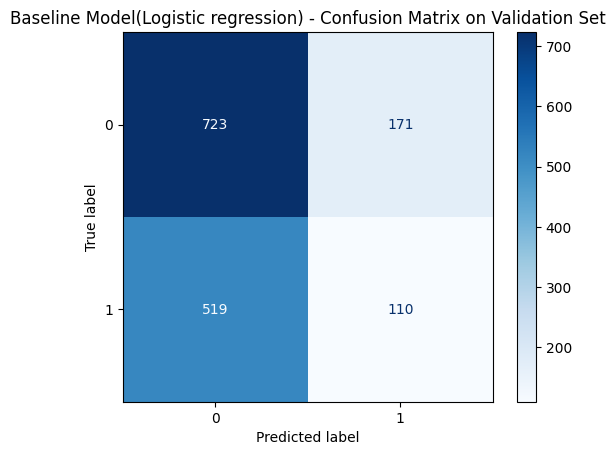

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1. Get validation set predictions
baseline_model.eval()
val_preds = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        inputs = inputs.float()

        outputs = baseline_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())

# y_val is your true labels (already created when splitting)
y_true = y_val  # numpy array of true validation labels

# 2. Create Confusion Matrix
cm = confusion_matrix(y_true, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# 3. Plot Confusion Matrix
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Baseline Model(Logistic regression) - Confusion Matrix on Validation Set')
plt.show()


We evaluate the baseline model by generating predictions on the validation set and then plot a confusion matrix to visualize the model’s classification performance, showing the counts of true positives, true negatives, false positives, and false negatives.



In [20]:
#  4. Classification Report
print("Classification Report of Logistic Regression:")
print(classification_report(y_true, val_preds, digits=4))


Classification Report of Logistic Regression:
              precision    recall  f1-score   support

           0     0.5821    0.8087    0.6770       894
           1     0.3915    0.1749    0.2418       629

    accuracy                         0.5469      1523
   macro avg     0.4868    0.4918    0.4594      1523
weighted avg     0.5034    0.5469    0.4972      1523



# BiLSTM Model Evaluation metrics

In [21]:
# Load the best model
net.load_state_dict(torch.load('state_dict.pt'))

# Evaluate on validation set
net.eval()
y_preds = []
y_true = []
y_probs = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        # Move data to GPU if available
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels

        # Initialize hidden state based on actual batch size
        val_h = net.init_hidden(inputs.size(0), train_on_gpu)
        val_h = tuple([each.data for each in val_h])

        outputs, val_h = net(inputs, val_h)

        # Save predictions for evaluation metrics
        probs = outputs.squeeze().detach().cpu().numpy()
        preds = torch.round(outputs.squeeze())
        y_probs.extend(probs)
        y_preds.extend(preds.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())

# Calculate evaluation metrics on validation set
accuracy = accuracy_score(y_true, y_preds)
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds)
confusion = confusion_matrix(y_true, y_preds)

print("\nEvaluation Metrics on Validation Set for BiLSTM model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("Confusion Matrix:")
print(confusion)



Evaluation Metrics on Validation Set for BiLSTM model:
Accuracy: 0.8063
Precision: 0.8287
Recall (Sensitivity): 0.6693
F1-Score: 0.7405
Confusion Matrix:
[[807  87]
 [208 421]]


We load the best saved BiLSTM model and evaluate it on the validation set by generating predictions. We compute key evaluation metrics including accuracy, precision, recall, F1-score, and display the confusion matrix to analyze the model’s classification performance in detail.



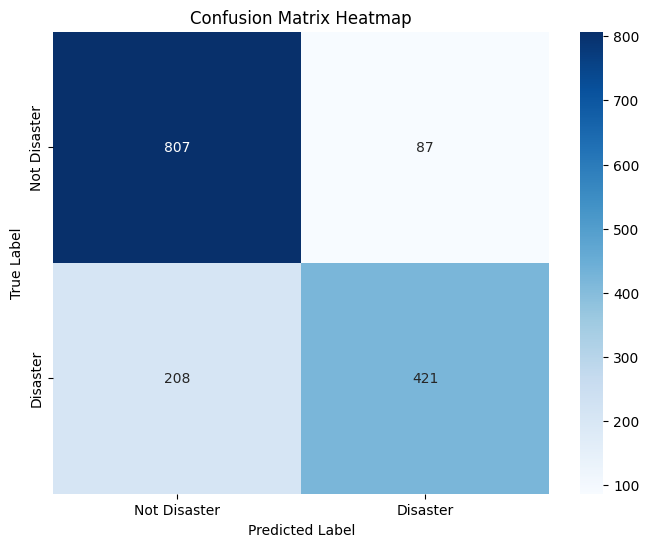

In [22]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


We plot a heatmap of the confusion matrix to visually represent the model’s prediction performance, clearly showing the number of correctly and incorrectly classified disaster and non-disaster tweets using color intensity.



# Visualizations


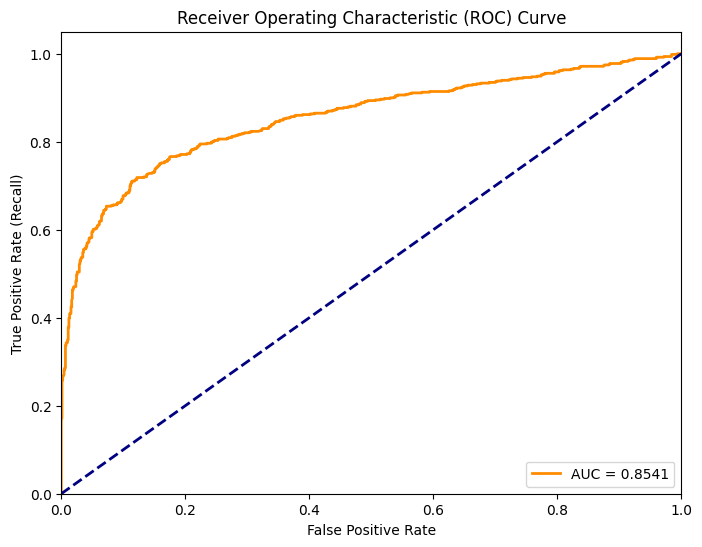

In [23]:
# ROC Curve of BiLSTM model
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='darkorange', lw=2)
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


We plot the ROC curve for the BiLSTM model to evaluate its ability to distinguish between disaster and non-disaster tweets. The Area Under the Curve (AUC) value summarizes the model’s overall classification performance across different threshold settings.



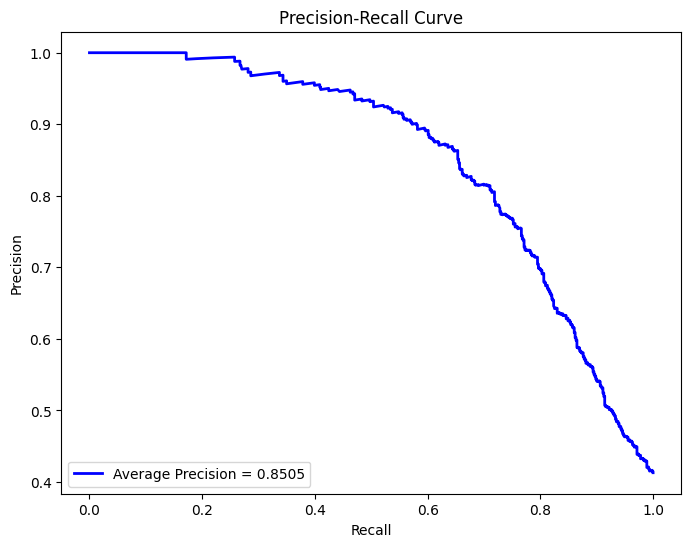

In [24]:
# Precision-Recall Curve of BiLSTM model
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall_vals, precision_vals, label=f'Average Precision = {avg_precision:.4f}', color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


We plot the Precision-Recall curve for the BiLSTM model to assess its performance, especially on imbalanced datasets. The average precision score summarizes the trade-off between precision and recall across different classification thresholds.



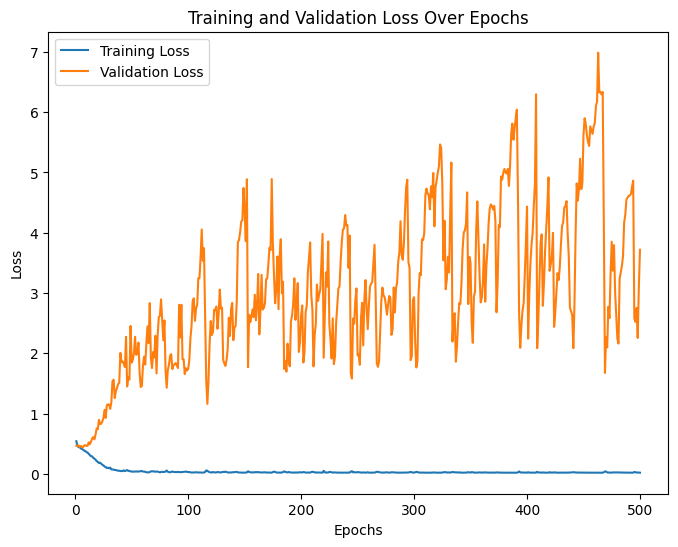

In [25]:
# Training and Validation Loss Curves of BiLSTM model
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses_epoch, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


We plot the training and validation loss curves over epochs to monitor the learning process of the BiLSTM model. These curves help identify signs of overfitting or underfitting and ensure that the model is learning effectively during training.



In [26]:
# Create DataLoader for test set
test_data = TensorDataset(torch.from_numpy(test_padded))
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize hidden state
net.eval()
test_preds = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0]
        if train_on_gpu:
            inputs = inputs.cuda()
        else:
            inputs = inputs

        h = net.init_hidden(inputs.size(0), train_on_gpu)
        h = tuple([each.data for each in h])

        outputs, h = net(inputs, h)

        preds = torch.round(outputs.squeeze())
        test_preds.extend(preds.detach().cpu().numpy())

# Ensure the number of predictions matches test set size
test_preds = test_preds[:len(test)]


We use the trained BiLSTM model to generate predictions on the unseen test dataset. The model outputs are thresholded to obtain binary class predictions (disaster or non-disaster) for each tweet in the test set.



In [27]:
# Save weights_matrix to a file
np.save('weights_matrix.npy', weights_matrix.numpy())


In [28]:
pip install streamlit pyngrok


In [29]:
# Install necessary packages

# Authenticate ngrok
from pyngrok import ngrok
ngrok.set_auth_token('2mdzC5PhaSZt0Kh7DcRfqbT4pfK_366JmJjiSDP9qLC8ZrTSH')  # Replace with your actual token


We install the necessary packages and authenticate ngrok using a personal token. This allows us to create a secure public URL to deploy and share our Streamlit app hosted locally.




# Streamlit App

In [32]:
# Run the Streamlit app
import subprocess
import threading

def run_app():
    subprocess.call(['streamlit', 'run', 'app.py', '--server.port', '8501', '--server.headless', 'true'])

thread = threading.Thread(target=run_app)
thread.start()

# Expose the app using ngrok
public_url = ngrok.connect(8501)
print(f'Access your app at: {public_url}')


Access your app at: NgrokTunnel: "https://7dcf-34-142-202-202.ngrok-free.app" -> "http://localhost:8501"


We run the Streamlit app in a separate thread and expose it to the internet using ngrok, creating a public URL. This allows users to easily access and interact with the deployed disaster tweet classification application.

